In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
from sklearn import preprocessing

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [28]:
## Owing to KxN structure of the dot product, bias should be of the shape Kx1
def softmax(features,coefficients,bias,include_bias=0):
    ## Here the shape of the dot product is tranposed so as to allow efficient subtraction    
    dp = np.dot(features,coefficients).transpose().astype('float32') + include_bias*bias
    const = np.max(dp,axis=0)
    return np.exp(dp-const)/np.sum(np.exp(dp-const),axis=0)

In [31]:
def logistic_regression(features,coefficients,labels,step_size=0.001,max_iter=1000):
    coeff_dim = np.shape(coefficients)
    features_dim = np.shape(features)
    bias = np.ones((1,coeff_dim[1]))
    features_bias = np.ones((features_dim[0],1))
    print np.shape(features_bias)
    print features_dim
    
    coefficients_with_bias = np.vstack((bias,coefficients))
    features_with_bias = np.hstack((features_bias,features))
    print features_with_bias
    coeff_dim = np.shape(coefficients_with_bias)
    features_dim = np.shape(features_bias)
        
    for _ in range(1000):
        ## softmax probabilities - shape (KxN)
        probs = softmax(features_with_bias,coefficients_with_bias,bias.T)

        ## backpropagation
        probs[labels,range(features_dim[0])] = probs[labels,range(features_dim[0])] - 1
        coefficients_with_bias = coefficients_with_bias - step_size*(np.dot(features_with_bias.T,probs.T))
    
    return coefficients_with_bias

In [22]:
x = np.array([[1,2,3,4],[4,5,6,7],[7,7,9,10]])
y = np.array([[1,2,1],[2,1,4]])
b = np.ones((4,1))
z = softmax(y,x,b)
print z

[[  6.03293347e-06   7.57565233e-10]
 [  1.21174700e-04   1.52161022e-08]
 [  1.79839209e-02   9.11051116e-04]
 [  9.81888831e-01   9.99088883e-01]]


In [32]:
#labels = np.random.random_integers(low=0,high=1,size=2)
labels = [0,1]
print logistic_regression(y,x,labels)

(2L, 1L)
(2L, 3L)
[[ 1.  1.  2.  1.]
 [ 1.  2.  1.  4.]]
[[ 1.91480233  1.27502044  0.64658281  0.16359442]
 [ 1.91212418  2.78208909  2.50479708  2.80098965]
 [ 5.83228281  5.04297223  5.43495135  5.68979361]
 [ 7.90676788  8.79622639  8.22122561  8.07578012]]


In [103]:
## features - NxD
#  coefficients - DxK
#  lables - Nx1
def logistic_regression_inclusive_bias(features,coefficients,labels,step_size=0.001,max_iter=1000,lamda=0.1):
    coeff_dim = np.shape(coefficients)
    features_dim = np.shape(features)
    bias = np.ones((coeff_dim[1],1))
    
    for _ in range(max_iter):
        ## softmax probabilities - shape (KxN)
        probs = softmax(features,coefficients,bias,include_bias=1)

        ## backpropagation
        probs[labels,range(features_dim[0])] = probs[labels,range(features_dim[0])] - 1
        #probs /= features_dim[0] 
        coefficients = coefficients - step_size*(np.dot(features.T,probs.T) + 2*lamda*coefficients)
    
    return coefficients

In [79]:
# Here the inputs coefficients and features should satisfy the dimensionality matching criteria 
def compute_accuracy(coefficients,features,output_labels):
    ''' coefficients = (num_features,num_classes)
        features = (num_inputs,num_features)
        prediction_dot_product = (num_inputs,num_classes)
        Thus, we have to find the index of the class with maximum score in axis=0
        '''
    features_dim = np.shape(features)
    prediction = np.argmax(np.dot(features,model),axis=1)
    accuracy = (prediction==output_labels)
    return np.sum(accuracy,dtype='float32')*100/features_dim[0]

In [46]:
print logistic_regression_inclusive_bias(y,x,labels,lamda=0.1)

[[ 1.65654745  2.33628263  2.00515509  2.1891586 ]
 [ 4.96060011  4.16082751  4.38997593  4.50031274]
 [ 6.56211608  7.31682259  6.66433085  6.47430491]]


## Multinomial Regression over MNIST

In [2]:
with open("G:\Miscellaneous\python\Utilities\Datasets\mnist.pkl",'rb') as mnist_file:
    train_data,valid_data,test_data = cPickle.load(mnist_file)

4


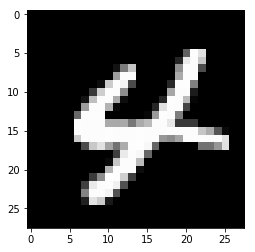

In [3]:
## In this block we are shuffling the data to avoid any classification bias
train_vec_in,train_label_out = train_data
permutation = np.random.permutation(train_vec_in.shape[0])
train_vec_in = train_vec_in[permutation,:]
train_reshape = np.reshape(train_vec_in,newshape=[50000,28,28])
train_label_out = train_label_out[permutation]

plt.imshow(train_reshape[3],cmap='gray')
print train_label_out[3]

In [4]:
valid_features,valid_labels = valid_data
test_features,test_labels = test_data

In [226]:
def feature_scaling(features):
    std = np.std(features,axis=0)
    ind = np.where(std == 0)
    std[ind] = 1
    return (features-np.mean(features,axis=0))/std

In [113]:
classes = set(train_label_out)
step_size = 1e-4
coefficients = np.zeros(shape=(np.shape(train_vec_in)[1],len(classes)))
model = logistic_regression_inclusive_bias(train_vec_in,coefficients,train_label_out,step_size,max_iter=100,lamda=0.1)

In [115]:
print "Accuracy on Training Set is {}%".format(compute_accuracy(model,train_vec_in,train_label_out))
print "Accuracy on Test Set is {}%".format(compute_accuracy(model,test_features,test_labels))
print "Accuracy on Validation Set is {}%".format(compute_accuracy(model,valid_features,valid_labels))

Accuracy on Training Set is 90.426%
Accuracy on Test Set is 91.04%
Accuracy on Validation Set is 91.3%


In [75]:
print np.shape(test_features)
print np.shape(test_labels)

(10000L, 784L)
(10000L,)


## 2-Layer Neural Network using ReLUs

In [5]:
def confusion_matrix(predicted_outcome,labels):
    classes = set(labels)
    num_classes = len(classes)
    conf_mat = np.zeros((num_classes,num_classes))
    for i in classes:
        for j in classes:
            conf_mat[i,j] = len(np.where((labels == i) & (predicted_outcome == j))[0])
    
    false_positives = np.sum(conf_mat,axis=0)
    false_negatives = np.sum(conf_mat,axis=1)
    precision = np.array([conf_mat[i,i]/false_positives[i] for i in range(10)])
    recall = np.array([conf_mat[i,i]/false_negatives[i] for i in range(10)])
    return precision,recall

In [6]:
def two_layer_nn(features,labels,valid_features,valid_labels,hidden_sz=100,lamda=0.001,step_size=1,max_iter=100):
    features_dim= np.shape(features)
    classes = set(labels)
    coeff_1 = 0.01 * np.random.randn(features_dim[1],hidden_sz)/(np.sqrt(features_dim[1]))
    coeff_2 = 0.01 * np.random.randn(hidden_sz,len(classes))/(np.sqrt(hidden_sz))

    coeff1_dim = np.shape(coeff_1)    
    coeff2_dim = np.shape(coeff_2)
    bias_1 = 0.01 * np.random.randn(1,coeff1_dim[1])
    bias_2 = 0.01 * np.random.randn(1,coeff2_dim[1])
    #bias_1 = np.zeros((1,coeff1_dim[1]))
    #bias_2 = np.zeros((1,coeff2_dim[1]))

    tot_cost = []
    
    print 'Training model for lamda:%.4f, and step_size: %.4f' % (lamda,step_size)
    
    for _ in xrange(max_iter):
        #### Layer - 1 ####
        reLU = np.maximum(0,np.dot(features,coeff_1) + bias_1)   # reLU - shape (Nxh)

        ## without equalization ##
        #l2_scores = np.dot(reLU,coeff_2) + bias_2  # [NxK]
        #exp_scores = np.exp(l2_scores)
        #probs_scores = exp_scores/np.sum(exp_scores,axis=1,keepdims=True)  # probs - shape(NxK)

        ## with max-equalization ##
        l2_scores = np.transpose(np.dot(reLU,coeff_2) + bias_2) # [KxN]
        l2_scores_max = np.max(l2_scores,axis=0) # [1xN]
        exp_scores = np.exp(l2_scores-l2_scores_max)
        probs_scores = exp_scores/np.sum(exp_scores,axis=0,keepdims=True)  # probs - shape(KxN)

        ## Loss computation
        tot_cost.append(-np.sum(probs_scores[labels,range(features_dim[0])])/features_dim[0])
        
        # backpropagation
        probs = np.transpose(probs_scores) # shape - NxK
        probs[range(features_dim[0]),labels] -= 1
        probs /= features_dim[0]

        dcoeff_2 = np.dot(reLU.T,probs)   # dcoeff_2 - shape(hxK)
        dbias_2 = np.sum(probs, axis=0, keepdims=True)
        dhidden_layer = np.dot(probs,coeff_2.T)   # dhidden - shape(Nxh)
        dhidden_layer[reLU <= 0] = 0
        dcoeff_1 = np.dot(features.T,dhidden_layer)
        dbias_1 = np.sum(dhidden_layer, axis=0, keepdims=True)

        coeff_2 += -step_size*(dcoeff_2 + lamda*coeff_2)  # coeff_2 - shape(hxK)
        coeff_1 += -step_size*(dcoeff_1 + lamda*coeff_1)  # coeff_1 - shape(Dxh)
        bias_1 += -step_size * dbias_1
        bias_2 += -step_size * dbias_2
        
    ##### Training Data accuracy #####
    hidden_layer_train = np.maximum(0,np.dot(features,coeff_1)+bias_1)
    scores_train = np.dot(hidden_layer_train,coeff_2)+bias_2
    predicted_class_train = np.argmax(scores_train, axis=1)
    print 'training accuracy: %.2f' % (np.mean(predicted_class_train == labels))
    #precision_train,recall_train = confusion_matrix(predicted_class_train,labels)
    #print 'training mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_train),np.mean(recall_train))

    ##### Validation Data accuracy #####
    hidden_layer_valid = np.maximum(0,np.dot(valid_features,coeff_1)+bias_1)
    scores_valid = np.dot(hidden_layer_valid,coeff_2)+bias_2
    predicted_class_valid = np.argmax(scores_valid,axis=1)
    print 'validation accuracy: %.2f' % (np.mean(predicted_class_valid == valid_labels))
    #precision_valid,recall_valid = confusion_matrix(predicted_class_valid,valid_labels)
    #print 'validation mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_valid),np.mean(recall_valid))   
        
    return coeff_1,bias_1,coeff_2,bias_2,tot_cost

In [7]:
print np.logspace(-4,3,num=10)

[  1.00000000e-04   5.99484250e-04   3.59381366e-03   2.15443469e-02
   1.29154967e-01   7.74263683e-01   4.64158883e+00   2.78255940e+01
   1.66810054e+02   1.00000000e+03]


In [120]:
''' Trained the model using the Grid Search Technique for Lamda.
Given the randomness in weight initialization - lamda should be given in range (0.0001,0.001)'''
#lamda = np.logspace(-4,0,num=10)
lamda = np.logspace(-4,-3,num=4)
for elem in lamda:
    coeff_1,bias_1,coeff_2,bias_2 = two_layer_nn(features,labels,valid_features,valid_labels, \
                                             hidden_sz=100,lamda=elem,step_size=1,max_iter=50)

Training model for lamda:0.0001, and step_size: 1.0000
training accuracy: 0.91
training mean precision: 0.9105, mean recall: 0.9048
validation accuracy: 0.92
validation mean precision: 0.9222, mean recall: 0.9177
Training model for lamda:0.0002, and step_size: 1.0000
training accuracy: 0.91
training mean precision: 0.9104, mean recall: 0.9053
validation accuracy: 0.92
validation mean precision: 0.9199, mean recall: 0.9165
Training model for lamda:0.0005, and step_size: 1.0000
training accuracy: 0.92
training mean precision: 0.9213, mean recall: 0.9208
validation accuracy: 0.93
validation mean precision: 0.9282, mean recall: 0.9275
Training model for lamda:0.0010, and step_size: 1.0000
training accuracy: 0.92
training mean precision: 0.9216, mean recall: 0.9215
validation accuracy: 0.93
validation mean precision: 0.9299, mean recall: 0.9294


In [128]:
## Here using lamda = 0.0005, we'll do a grid sweep for Step Size. 
# Reducing the step_size will require more number of iterations for optimization
step_size = [0.1,0.5,1,1.5,2,2.5,3,5,7.5,10]
for step in step_size:
    coeff_1,bias_1,coeff_2,bias_2 = two_layer_nn(features,labels,valid_features,valid_labels, \
                                             hidden_sz=100,lamda=0.0005,step_size=step,max_iter=50)

Training model for lamda:0.0005, and step_size: 0.1000
training accuracy: 0.77
training mean precision: 0.7779, mean recall: 0.7670
validation accuracy: 0.80
validation mean precision: 0.8016, mean recall: 0.7903
Training model for lamda:0.0005, and step_size: 0.5000
training accuracy: 0.90
training mean precision: 0.9016, mean recall: 0.9012
validation accuracy: 0.91
validation mean precision: 0.9096, mean recall: 0.9097
Training model for lamda:0.0005, and step_size: 1.0000
training accuracy: 0.90
training mean precision: 0.9066, mean recall: 0.9030
validation accuracy: 0.91
validation mean precision: 0.9156, mean recall: 0.9133
Training model for lamda:0.0005, and step_size: 1.5000
training accuracy: 0.31
training mean precision: nan, mean recall: 0.2962
validation accuracy: 0.30
validation mean precision: nan, mean recall: 0.3002
Training model for lamda:0.0005, and step_size: 2.0000


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


training accuracy: 0.11
training mean precision: nan, mean recall: 0.1001
validation accuracy: 0.11
validation mean precision: nan, mean recall: 0.1002
Training model for lamda:0.0005, and step_size: 2.5000
training accuracy: 0.11
training mean precision: nan, mean recall: 0.1000
validation accuracy: 0.11
validation mean precision: nan, mean recall: 0.1000
Training model for lamda:0.0005, and step_size: 3.0000
training accuracy: 0.11
training mean precision: nan, mean recall: 0.1000
validation accuracy: 0.11
validation mean precision: nan, mean recall: 0.1000
Training model for lamda:0.0005, and step_size: 5.0000
training accuracy: 0.12
training mean precision: nan, mean recall: 0.1074
validation accuracy: 0.11
validation mean precision: nan, mean recall: 0.1083
Training model for lamda:0.0005, and step_size: 7.5000
training accuracy: 0.11
training mean precision: nan, mean recall: 0.1000
validation accuracy: 0.11
validation mean precision: nan, mean recall: 0.1000
Training model for l

In [8]:
coeff_1,bias_1,coeff_2,bias_2,tot_cost = two_layer_nn(train_vec_in,train_label_out,valid_features,valid_labels, \
                                             hidden_sz=100,lamda=0.001,step_size=1,max_iter=2000)

##### Test Data accuracy #####
hidden_layer_test = np.maximum(0,np.dot(test_features,coeff_1)+bias_1)
scores_test = np.dot(hidden_layer_test,coeff_2)+bias_2
predicted_class_test = np.argmax(scores_test,axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class_test == test_labels))
precision_test,recall_test= confusion_matrix(predicted_class_test,test_labels)
print 'test mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_test),np.mean(recall_test))

Training model for lamda:0.0010, and step_size: 1.0000
training accuracy: 0.97
validation accuracy: 0.96
test accuracy: 0.96
test mean precision: 0.9620, mean recall: 0.9615


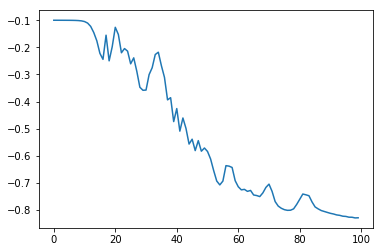

In [27]:
plt.plot(tot_cost)
plt.show()

In [253]:
train_scaled = feature_scaling(train_vec_in)

In [104]:
features = train_vec_in
hidden_sz = 100
classes = set(train_label_out)
features_dim = np.shape(features)
labels = train_label_out
lamda = 0.001
step_size = 1

coeff_1 = 0.01 * np.random.randn(features_dim[1],hidden_sz)
coeff_2 = 0.01 * np.random.randn(hidden_sz,len(classes))
    
coeff1_dim = np.shape(coeff_1)    
coeff2_dim = np.shape(coeff_2)
bias_1 = np.zeros((1,coeff1_dim[1]))
bias_2 = np.zeros((1,coeff2_dim[1]))
    
for _ in xrange(100):
    #### Layer - 1 ####
    reLU = np.maximum(0,np.dot(features,coeff_1) + bias_1)   # reLU - shape (Nxh)
    
    ## without equalization ##
    #l2_scores = np.dot(reLU,coeff_2) + bias_2  # [NxK]
    #exp_scores = np.exp(l2_scores)
    #probs_scores = exp_scores/np.sum(exp_scores,axis=1,keepdims=True)  # probs - shape(NxK)

    ## with max-equalization ##
    l2_scores = np.transpose(np.dot(reLU,coeff_2) + bias_2) # [KxN]
    l2_scores_max = np.max(l2_scores,axis=0) # [1xN]
    exp_scores = np.exp(l2_scores-l2_scores_max)
    probs_scores = exp_scores/np.sum(exp_scores,axis=0,keepdims=True)  # probs - shape(KxN)
    
    # backpropagation
    probs = np.transpose(probs_scores) # shape - NxK
    probs[range(features_dim[0]),labels] -= 1
    probs /= features_dim[0]

    dcoeff_2 = np.dot(reLU.T,probs)   # dcoeff_2 - shape(hxK)
    dbias_2 = np.sum(probs, axis=0, keepdims=True)
    dhidden_layer = np.dot(probs,coeff_2.T)   # dhidden - shape(Nxh)
    dhidden_layer[reLU <= 0] = 0
    dcoeff_1 = np.dot(features.T,dhidden_layer)
    dbias_1 = np.sum(dhidden_layer, axis=0, keepdims=True)

    coeff_2 += -step_size*(dcoeff_2 + lamda*coeff_2)  # coeff_2 - shape(hxK)
    coeff_1 += -step_size*(dcoeff_1 + lamda*coeff_1)  # coeff_1 - shape(Dxh)
    bias_1 += -step_size * dbias_1
    bias_2 += -step_size * dbias_2

In [38]:
print np.shape(l2_scores)
print np.shape(l2_scores_max)
print np.shape(exp_scores)
print np.shape(probs_scores)
print np.shape(probs)
print np.shape(np.sum(exp_scores,axis=0,keepdims=True))

(10L, 50000L)
(50000L,)
(10L, 50000L)
(10L, 50000L)
(50000L, 10L)
(1L, 50000L)


In [105]:
##### Training Data accuracy #####
hidden_layer_1 = np.maximum(0,np.dot(train_vec_in,coeff_1)+bias_1)
scores_1 = np.dot(hidden_layer_1,coeff_2)+bias_2
predicted_class_1 = np.argmax(scores_1, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class_1 == train_label_out))
precision_train,recall_train = confusion_matrix(predicted_class_1,train_label_out)
print 'training mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_train),np.mean(recall_train))

##### Validation Data accuracy #####
hidden_layer_valid = np.maximum(0,np.dot(valid_features,coeff_1)+bias_1)
scores_valid = np.dot(hidden_layer_valid,coeff_2)+bias_2
predicted_class_valid = np.argmax(scores_valid,axis=1)
print 'validation accuracy: %.2f' % (np.mean(predicted_class_valid == valid_labels))
precision_valid,recall_valid = confusion_matrix(predicted_class_valid,valid_labels)
print 'validation mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_valid),np.mean(recall_valid))

##### Test Data accuracy #####
hidden_layer_test = np.maximum(0,np.dot(test_features,coeff_1)+bias_1)
scores_test = np.dot(hidden_layer_test,coeff_2)+bias_2
predicted_class_test = np.argmax(scores_test,axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class_test == test_labels))
precision_test,recall_test= confusion_matrix(predicted_class_test,test_labels)
print 'test mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_test),np.mean(recall_test))

training accuracy: 0.90
training mean precision: 0.9068, mean recall: 0.9028
validation accuracy: 0.91
validation mean precision: 0.9154, mean recall: 0.9114
test accuracy: 0.91
test mean precision: 0.9093, mean recall: 0.9055


In [390]:
print np.shape(hidden)

(50000L, 100L)


In [44]:
# initialize parameters randomly
D = 784
K = 10
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-4 # regularization strength

X = train_vec_in
y = train_label_out

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(100):
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
  
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W
  
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 2.302802


In [45]:
##### Training Data accuracy #####
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class_2 = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class_2 == y))
precision_train_2,recall_train_2 = confusion_matrix(predicted_class_2,train_label_out)
print 'training mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_train_2),np.mean(recall_train_2))

##### Validation Data accuracy #####
hidden_layer_valid_2 = np.maximum(0,np.dot(valid_features, W) + b)
scores_valid_2 = np.dot(hidden_layer_valid_2,W2) + b2
predicted_class_valid_2 = np.argmax(scores_valid_2,axis=1)
print 'validation accuracy: %.2f' % (np.mean(predicted_class_valid_2 == valid_labels))
precision_valid_2,recall_valid_2 = confusion_matrix(predicted_class_valid_2,valid_labels)
print 'validation mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_valid_2),np.mean(recall_valid_2))

##### Test Data accuracy #####
hidden_layer_test_2 = np.maximum(0,np.dot(test_features, W) + b)
scores_test_2 = np.dot(hidden_layer_test_2,W2) + b2
predicted_class_test_2 = np.argmax(scores_test_2,axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class_test_2 == test_labels))
precision_test_2,recall_test_2= confusion_matrix(predicted_class_test_2,test_labels)
print 'test mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_test_2),np.mean(recall_test_2))

training accuracy: 0.92
training mean precision: 0.9148, mean recall: 0.9137
validation accuracy: 0.92
validation mean precision: 0.9211, mean recall: 0.9202
test accuracy: 0.92
test mean precision: 0.9205, mean recall: 0.9195


In [100]:
precision,recall = confusion_matrix(predicted_class_1,train_label_out)
print np.mean(precision)
print np.mean(recall)

0.976418154316
0.976314624215


In [52]:
x = predicted_class_valid == valid_labels
y = np.where(x == True)
print len(y[0])

9706


In [51]:
import pkgutil
import sklearn
package = sklearn

for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print "Found submodule %s (is a package: %s)" % (modname, ispkg)

Found submodule __check_build (is a package: True)
Found submodule _build_utils (is a package: False)
Found submodule _isotonic (is a package: False)
Found submodule base (is a package: False)
Found submodule calibration (is a package: False)
Found submodule cluster (is a package: True)
Found submodule covariance (is a package: True)
Found submodule cross_decomposition (is a package: True)
Found submodule cross_validation (is a package: False)
Found submodule datasets (is a package: True)
Found submodule decomposition (is a package: True)
Found submodule discriminant_analysis (is a package: False)
Found submodule dummy (is a package: False)
Found submodule ensemble (is a package: True)
Found submodule externals (is a package: True)
Found submodule feature_extraction (is a package: True)
Found submodule feature_selection (is a package: True)
Found submodule gaussian_process (is a package: True)
Found submodule grid_search (is a package: False)
Found submodule isotonic (is a package: Fal